<h1>Data Exctraction - Huelse</h1>

This notebooks goal is to display the distribution of material in "Hülse". For this I am using a tree structure.

In [1]:
import pandas as pd
import plotly.express as px
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pipe_helpers as hp

In [2]:
mat_hülsen = pd.read_excel("./06 - Spezifikation DE-EN_Vorlage_CAD.xlsx", sheet_name="02_Material Hülse")

In [3]:
mat_hülsen_cp = (mat_hülsen.pipe(hp.start_pipeline)
    .pipe(hp.rename_column, column_name="Unnamed: 0", value="SAP_MATNR")
    .pipe(hp.drop_columns, column_names=["Unnamed: 4","Unnamed: 5","Unnamed: 6","Unnamed: 7"])
    .pipe(hp.filterNaN_rows, column_names=["Material"])
    .pipe(hp.replace_character, column_names=[("Material",r'1(-)\d', ".")])
    .pipe(hp.extract_from_regex, column_names=[("Material_extract","Material",r'(\d[\.]\d{4}|CuZn.{4}|CW.{4}|.*)'),("Material_Class", "Material_extract",r'(\d[\.\-]\d|EN\sAW|Cu|CW|.*)')])   
    )

just ran step start_pipeline shape=(267, 8) took 0:00:00s
just ran step rename_column shape=(267, 8) took 0:00:00.001018s
just ran step drop_columns shape=(267, 4) took 0:00:00s
just ran step filterNaN_rows shape=(260, 4) took 0:00:00.001204s
just ran step replace_character shape=(260, 4) took 0:00:00.002010s
just ran step extract_from_regex shape=(260, 6) took 0:00:00.002003s


<h2>Visualize the Different types of sensors</h2>

Here I build a tree where the different sensorcategories get visualized. For that I split after the category and the "B_Wert" or the "Widerstand"

In [4]:
import pandas as pd
from anytree import Node, RenderTree, PreOrderIter

# Focus on relevant columns and handle missing data
data_clean = mat_hülsen_cp[['Material', 'Material_extract', 'Material_Class']].fillna('Unknown')

# Initialize the root of the tree and main categories
root = Node("Material", count=0)
number_node = Node("Edelstahl ", parent=root, count=0)
en_node = Node("Ens", parent=root, count=0)
cu_node = Node("Cus", parent=root, count=0)
cw_node = Node("CWs", parent=root, count= 0)
others_node = Node("Others", parent=root, count=0)

# Populate the tree and count rows
for _, row in data_clean.iterrows():
    materialclass, material_extract = row['Material_Class'], row['Material_extract']
    
    # Determine the category and add specific nodes
    if re.match(r"\d[\.]\d", materialclass):
        parent_node = number_node
    elif re.match(r"EN", materialclass):
        parent_node = en_node
    elif re.match(r"Cu", materialclass):
        parent_node = cu_node
    elif re.match(r"CW", materialclass):
        parent_node = cw_node
    else:
        parent_node = others_node
    
    # Increment count for the category
    parent_node.count += 1
    root.count +=1
    
    # Create or fetch the sensor node
    sensor_node_name = f"{materialclass}"
    sensor_node = next((child for child in parent_node.children if child.name.startswith(sensor_node_name)), None)
    if not sensor_node:
        sensor_node = Node(sensor_node_name, parent=parent_node, count=0)
    sensor_node.count += 1

    # Further classify PTs by 'PT_Class' and NTCs by 'Widerstand'
    if parent_node != 'Unknown':
        class_node_name = f"Type: {material_extract}"
        class_node = next((child for child in sensor_node.children if child.name == class_node_name), None)
        if not class_node:
            class_node = Node(class_node_name, parent=sensor_node, count=0)
        class_node.count += 1
    """ elif parent_node == root and widerstand != 'Unknown':
        root.count -=1
        widerstand_node_name = f"Widerstand: {widerstand}"
        widerstand_node = next((child for child in sensor_node.children if child.name == widerstand_node_name), None)
        if not widerstand_node:
            widerstand_node = Node(widerstand_node_name, parent=sensor_node, count=0)
        widerstand_node.count += 1

        if b_wert != 'Unknown':
            b_wert_node_name = f'{widerstand} B_Wert: {b_wert}'
            b_wert_node = next((child for child in widerstand_node.children if child.name == b_wert_node_name), None)
            if not b_wert_node:
                b_wert_node = Node(b_wert_node_name, parent=widerstand_node, count=0)
            b_wert_node.count += 1 """

# Update node names with counts
for node in PreOrderIter(root):
    node.name = f"{node.name} ({node.count})"

# Print the tree structure
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))


Material (260)
├── Edelstahl  (167)
│   ├── 1.4 (164)
│   │   ├── Type: 1.4571 (27)
│   │   ├── Type: 1.4305 (13)
│   │   ├── Type: 1.4104 (3)
│   │   ├── Type: 1.4404 (114)
│   │   ├── Type: 1.4301 (5)
│   │   ├── Type: 1.4435 (1)
│   │   └── Type: 1.4541 (1)
│   ├── 2.4 (2)
│   │   └── Type: 2.4816 (2)
│   └── 3.1 (1)
│       └── Type: 3.1655 (1)
├── Ens (5)
│   └── EN AW (5)
│       ├── Type: EN AW-6061 (1)
│       ├── Type: EN AW 6061 (2)
│       ├── Type: EN AW-6061  (1)
│       └── Type: EN AW6012 (1)
├── Cus (13)
│   └── Cu (13)
│       ├── Type: CuZn36Pb (3)
│       ├── Type: CuZn37 (2)
│       ├── Type: CuZn39Pb (5)
│       ├── Type: CuZn38Pb (1)
│       ├── Type: CuZn35/C (1)
│       └── Type: Cu-ETP verzinnt (1)
├── CWs (10)
│   └── CW (10)
│       ├── Type: CW626N (1)
│       ├── Type: CW724R (4)
│       └── Type: CW614N (5)
└── Others (65)
    ├── 8055 (1)
    │   └── Type: 8055 (1)
    ├── SF-Cu (2)
    │   └── Type: SF-Cu (2)
    ├── ceramic C 795 (5)
    │   └── Type: c

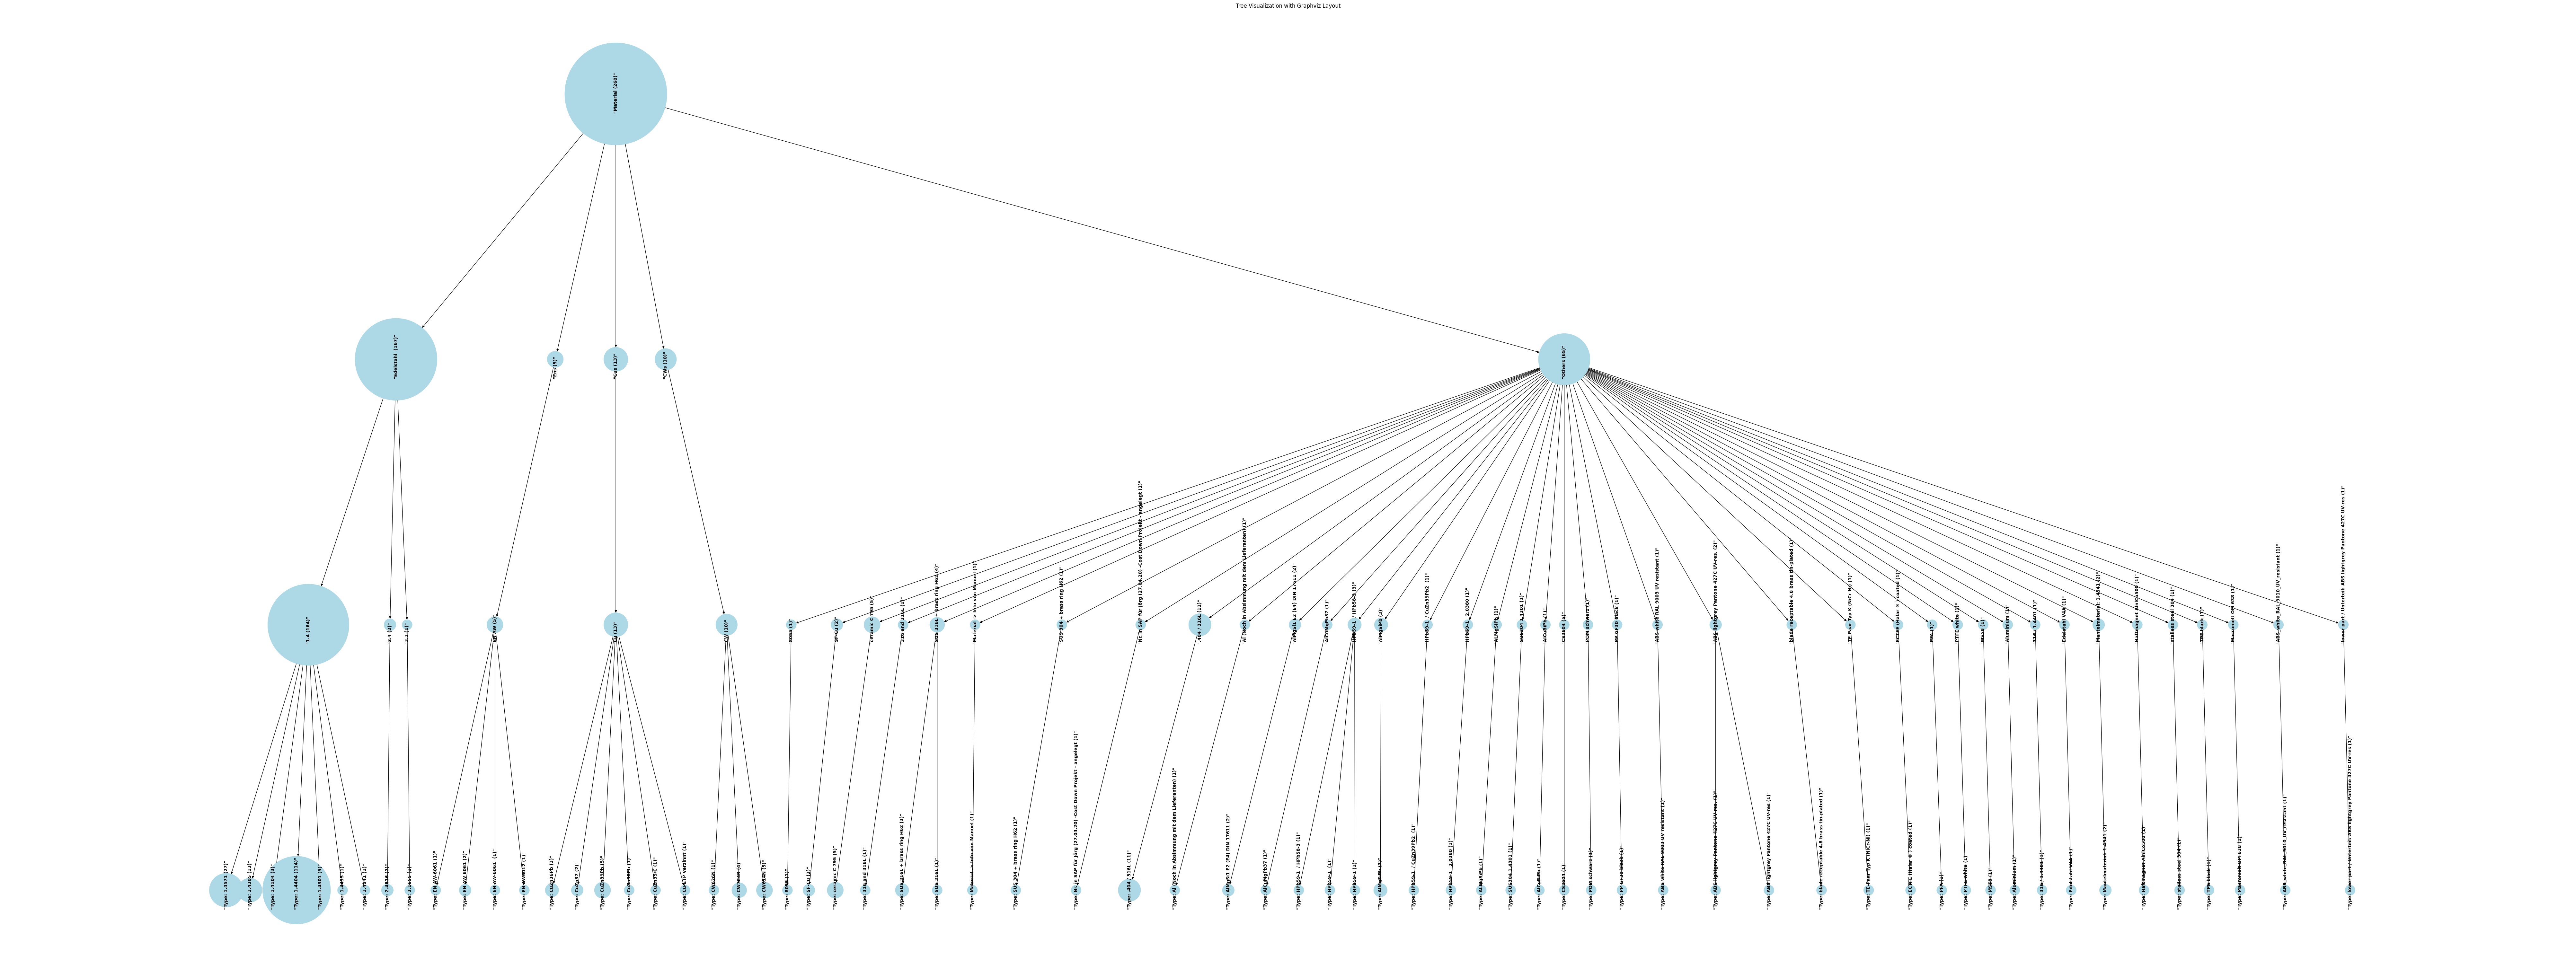

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

G = nx.DiGraph()

# A helper function to ensure node names are properly quoted if necessary
def format_node_name(name):
    # Check if the name contains special characters and quote it if it does
    if ':' in name or any(c in name for c in ['-', ' ', '(', ')', '[', ']', '{', '}']):
        return f'"{name}"'
    return name

# Function to add nodes and edges with formatted node names
def add_nodes_edges(node):
    for child in node.children:
        parent_name = format_node_name(node.name)
        child_name = format_node_name(child.name)
        G.add_edge(parent_name, child_name)  # Add an edge to the graph with formatted names
        add_nodes_edges(child)  # Recursive call to add nodes/edges for children

# Initialize the process with the root node
add_nodes_edges(root)

# Calculate node sizes based on the number of descendants (or any other metric)
node_sizes = {node: int(node[node.rfind("(")+1:node.rfind(")")])*200 + 300 for node in G.nodes()}  # Example metric: out_degree * 200 + 300


# Use the graphviz layout to draw the tree
plt.figure(figsize=(80, 30))  # Adjust the size of the figure as needed
pos = graphviz_layout(G, prog='dot')  # This uses the 'dot' layout
nx.draw(G, pos, with_labels=False, arrows=True, node_size=[node_sizes[node] for node in G.nodes()], node_color="lightblue", font_size=12, font_weight="bold")

# Custom labels drawing
label_pos = {key: (value[0], value[1] - 5) for key, value in pos.items()}  # Adjust label positions below nodes
for node, (x, y) in label_pos.items():
    plt.text(x, y, node, fontsize=10, fontweight="bold", ha='center', rotation=90)  # ha='center' centers the text horizontally at the position

plt.title('Tree Visualization with Graphviz Layout')
plt.show()